# 2D Map Inter/Exrtapolator  
The following code will set up a model to re-shape 2D ECU Maps due to a change on its axis

It consists of 2 models between you can chose:<br>
    - Tradicional linear interpolation / extrapolation model<br>
    - Enhanced resolution and softened model (PCHIP)

If you were to put a new setpoint onto the linear extrapolated setpoint function (Piecewise linear function), you'll be adding error from the original curve the engineers tried to replicate when the calibration was done. Either possitive or negative depending on concavity/convexity.

Assuming they already took this into account, (averaging the piecewise between a line tangent and point tangent), you'll be making error once every time you re-interpolate. But twice if they didn't.

If you chose to place new setpoints by using "Pchip" method, that will place them on a smooth curve based on the original setpoints that tries to recreate the original one by a special type of splines (Piecewise Cubic Hermite Interpolating Polynomial = PCHIP), less likely to overshoot than normal ones.

This notebook is configured by default to use them for interpolation, but to use linear for extrapolation.
As it's been tested, PCHIP extrapolation can get a strange beheavour so it's set to linear, much safer in this aspect.
Anyways, you could use both methods for both inter/extrapolation based on the final graph that'll be shown to evaluate results in a more friendly visual way

For further information and discussion, please visit the following OP:

### Libraries

In [68]:
# Loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import seaborn as sns
from scipy.interpolate import PchipInterpolator, interp1d
import re


### Loading your file

1) In WinOLS window, open the map you'd like to modify<br>
2) Go to Edit -> Copy advanced -> Copy map<br>
3) Paste it as plain text in a blank csv and save it<br>
4) Upload it to this colab<br>
4) Right click, copy path

In [ ]:
#Reading file:

input_path = "D:/DEV/Python/00_map_inter_extrapolator/KLMIMAX.csv" # Paste your path between the quotes

with open(input_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

### Code

In [70]:
# Formatting data
 
# Extract 'length' from 1st line
first_line = lines[0].strip()
match = re.search(r'x(\d+)\(', first_line[::-1])  # from right to left
length = int(match.group(1)[::-1]) if match else None

# Extract X_name and y_name from 3rd line
third_line = lines[2].strip()
x_part, y_part = third_line.split('/')
X_name = x_part.replace('(', '').replace(')', '').strip()
y_name = y_part.replace('(', '').replace(')', '').strip()

# Extract X_data from 6th line
sixth_line = lines[5].strip()
X_data = list(map(float, sixth_line.split('\t')[0:]))  # from 1st value onward

# Extract y_data from 7th line
seventh_line = lines[6].strip()
y_data = list(map(float, seventh_line.split('\t')[2:]))  # skip '-', '0'

# Create DataFrame
df = pd.DataFrame({X_name: X_data, y_name: y_data})



### Your map

In [71]:
display(df)

if (length == len(df)):
    print("All OK!")
else:
    print("Revise your data")

,Motordrehzahl,%
0,1000.0,82.813
1,1240.0,82.813
2,1480.0,82.813
3,2000.0,83.203
4,2520.0,83.984
5,3520.0,85.938
6,5000.0,87.109
7,6520.0,85.938


All OK!


### Code

In [72]:
# Adding setpoint weight column
df['weight'] = 0.0

#Expand original DF
df_expanded_ori = pd.DataFrame({X_name: np.linspace(min(df[df.columns[0]]), max(df[df.columns[0]]), num=10000), y_name: np.full(10000, np.nan)})
df_expanded_ori = pd.concat([df, df_expanded_ori])
df_expanded_ori = df_expanded_ori.drop_duplicates(subset=df_expanded_ori.columns[0], keep='first')
df_expanded_ori = df_expanded_ori.sort_values(df_expanded_ori.columns[0])
df_expanded_ori.reset_index(inplace=True, drop=True)
df_expanded_ori.drop(df_expanded_ori.columns[2], axis=1, inplace=True)

# Linear interpolation between original setpoints
df_expanded_lin = df_expanded_ori.copy()
df_expanded_lin[df_expanded_lin.columns[1]] = np.interp(df_expanded_lin[df_expanded_lin.columns[0]], df_expanded_lin.dropna()[df_expanded_lin.columns[0]], df_expanded_lin.dropna()[df_expanded_lin.columns[1]])
df_expanded_lin

# Adding columns for "df_aux_values" and "abs_error"
df_expanded_1 = df_expanded_lin.copy()
df_expanded_1[y_name+'_n-1_setpoints'] = np.nan
df_expanded_1['abs_error'] = 0.0
df_expanded_1

# Create lists with each one of the middle setpoints deleted
# To store graphs
figures = []
plt.ioff()
# index w/o first and last
for i in X_data[1:-1]:
    lista_sin_i = [x for x in X_data if x != i]
    df_aux = df[df[df.columns[0]].isin(lista_sin_i)]
    df_aux = df_aux.drop(columns = df.columns[2])
    # Asign '%' from df_aux to df_expanded_1 only where Motordrehzahl exists in df
    df_expanded_1.iloc[:, 2] = df_expanded_1.iloc[:, 0].map(df_aux.set_index(df_aux.columns[0])[df_aux.columns[1]])
    # Order by 'X' just in case
    df_expanded_1 = df_expanded_1.sort_values(df_expanded_1.columns[0])
    df_expanded_1.reset_index(inplace=True, drop=True)
    # Interpolate only NaN in '%'
    df_expanded_1[df_expanded_1.columns[2]] = np.interp(df_expanded_1[df_expanded_1.columns[0]], df_expanded_1.dropna()[df_expanded_1.columns[0]], df_expanded_1.dropna()[df_expanded_1.columns[2]])
    # Calculate error
    df_expanded_1.iloc[:, 3] = abs(df_expanded_1.iloc[:, 1] - df_expanded_1.iloc[:, 2])
    sumatorio_error = df_expanded_1['abs_error'].sum()
    df.loc[df.iloc[:, 0] == i, df.columns[2]] = sumatorio_error
    #Graph
    fig = plt.subplots(figsize=(8, 3))
    sns.lineplot(data=df_expanded_1, x=df_expanded_1.columns[0], y=df_expanded_1.columns[1], linewidth=4, label="All Setpoints")
    sns.lineplot(data=df_expanded_1, x=df_expanded_1.columns[0], y=df_expanded_1.columns[2], label="n-1 SetPoints")
    sns.scatterplot(data=df, x=df.columns[0], y=df.columns[1], s=75)
    plt.grid()
    plt.legend()
    plt.title(f"No SetPoint on {i}")
    figures.append(fig)
plt.close()

# Re establish df_expanded_1
# Linear interpolation between original setpoints
df_expanded_1[df_expanded_1.columns[1]] = np.interp(df_expanded_1[df_expanded_1.columns[0]], df_expanded_1.dropna()[df_expanded_1.columns[0]], df_expanded_1.dropna()[df_expanded_1.columns[1]])

# Multiple subplots
num_plots = len(figures)
fig, axes = plt.subplots(num_plots, 1, figsize=(8, 3 * num_plots))

# in case only 1 plot -> array
if num_plots == 1:
    axes = [axes]

# add figures to subplots
for idx, (fig_i, ax) in enumerate(zip(figures, axes)):
    original_ax = fig_i[1]
    for line in original_ax.get_lines():
        ax.plot(line.get_xdata(), line.get_ydata(), 
                label=line.get_label(), 
                linewidth=line.get_linewidth(),
                color=line.get_color())
    sns.scatterplot(data=df, x=df.columns[0], y=df.columns[1], s=75, ax=ax)
    ax.set_title(original_ax.get_title())
    ax.legend()
    ax.grid()
    plt.close(fig_i[0])
plt.tight_layout()


### SetPoint Evaluation

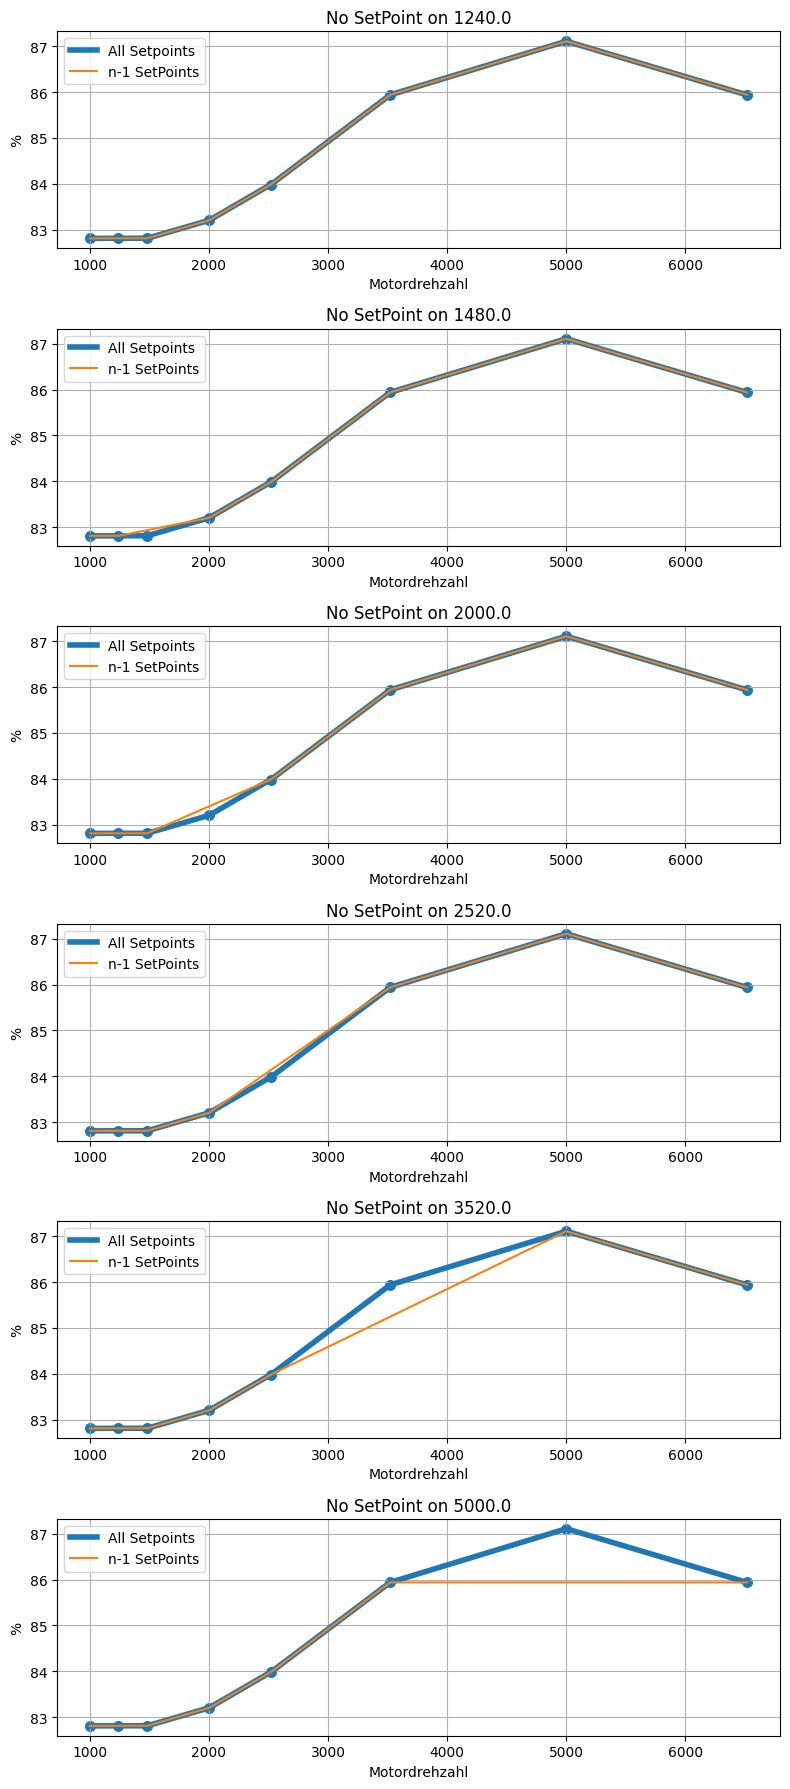

In [73]:
# This is how your map would look in case you just want to delete a current setpoint to put it out of the current defined zone (extgrapolation)
plt.show()

In [74]:
# This is how important each intermediate setpoint is (weight)
# Less importarnt first, so, less damaging to delete
# But you also can specify a totally new axes.
# Just pay attention to cover high curvature areas with your new setpoints

df[1:-1]

,Motordrehzahl,%,weight
1,1240.0,82.813,0.000000
2,1480.0,82.813,84.897280
3,2000.0,83.203,184.343749
4,2520.0,83.984,213.068146
5,3520.0,85.938,1559.342401
6,5000.0,87.109,3182.917953


### Axis modification

In [75]:
# Current Axis
print(X_data)
print(f'Number of SetPoints: {length}')

[1000.0, 1240.0, 1480.0, 2000.0, 2520.0, 3520.0, 5000.0, 6520.0]
Number of SetPoints: 8


In [76]:
# New Axis
# Fill in with the values you want, either for interpolation and extrapolation
# The number of setpoints has to remain equal

new_axis = np.array([1000.0, 1480.0, 2000.0, 3300.0, 4200.0, 5000.0, 5800.0, 6800.0]).astype(float)
print(f'Number of SetPoints: {len(new_axis)}')
if length == len(new_axis):
    print('All OK')
else:
    print('Please correct your axis so the number of setpoints remains equal')

Number of SetPoints: 8
All OK


### Code

In [77]:
# New Map creation
df_new_linear = df.copy()
df_new_linear.drop(df_new_linear.columns[2], axis=1, inplace=True)

# To know what values are original
# placing new setpoints onto the pchip curve,
# avoiding that way the piecewise quantization error
for i in new_axis:
    if i not in df[df_new_linear.columns[0]].values:
        df_new_linear = pd.concat([df_new_linear, pd.DataFrame({df_new_linear.columns[0]: [i]})], ignore_index=True)
df_new_linear = df_new_linear.sort_values(df_new_linear.columns[0], ascending = True).reset_index(drop=True)
df_new_linear[y_name+'_linear'] = df_new_linear[df_new_linear.columns[1]]
df_new_linear = df_new_linear.drop(df_new_linear.columns[1], axis=1)

# function for linear interpolation/extrapolation
interp_func = interp1d(
    df_new_linear.dropna(subset=[df_new_linear.columns[1]]).iloc[:, 0],  
    df_new_linear.dropna(subset=[df_new_linear.columns[1]]).iloc[:, 1],
    kind='linear',
    fill_value='extrapolate'
)

# Apply
df_new_linear.iloc[:, 1] = interp_func(df_new_linear.iloc[:, 0])

# New Map creation
df_new_pchip = df.copy()
df_new_pchip.drop(df_new_pchip.columns[2], axis=1, inplace=True)

# To know what values are original
# placing new setpoints onto the pchip curve,
# avoiding that way the piecewise quantization error
for i in new_axis:
    if i not in df[df_new_pchip.columns[0]].values:
        df_new_pchip = pd.concat([df_new_pchip, pd.DataFrame({df_new_pchip.columns[0]: [i]})], ignore_index=True)
df_new_pchip = df_new_pchip.sort_values(df_new_pchip.columns[0], ascending = True).reset_index(drop=True)
df_new_pchip[y_name+'_pchip'] = df_new_pchip[df_new_pchip.columns[1]]
df_new_pchip = df_new_pchip.drop(df_new_pchip.columns[1], axis=1)
# fill values
interp_pchip = PchipInterpolator(
    df_new_pchip.dropna(subset=[df_new_pchip.columns[0], df_new_pchip.columns[1]])[df_new_pchip.columns[0]].values,
    df_new_pchip.dropna(subset=[df_new_pchip.columns[0], df_new_pchip.columns[1]])[df_new_pchip.columns[1]].values,
    axis=0,
    extrapolate=True
)

# apply interpolation/extrapolation
df_new_pchip.iloc[:, 1] = interp_pchip(df_new_linear.iloc[:, 0])
df_new_combined = pd.concat([df_new_linear, df_new_pchip[df_new_pchip.columns[1]]], axis=1)
df_new_combined = df_new_combined[df_new_combined.iloc[:, 0].isin(new_axis)]
df_new_combined[y_name+'_chosen'] = 0.0
df_interp = df_new_combined[(df_new_combined.iloc[:, 0] >= min(X_data)) & (df_new_combined.iloc[:, 0] <= max(X_data))]
df_extrap = df_new_combined[(df_new_combined.iloc[:, 0] < min(X_data)) | (df_new_combined.iloc[:, 0] > max(X_data))]

### Interpolation and Extrapolation method

In [78]:
# Select method for interpolation and extrapolation (current selection, un-hashtagged, is the recommended)

#method_interp = 'Linear'
method_interp = 'Pchip'
method_extrap = 'Linear'
#method_extrap = 'Pchip'


### Code

In [79]:
if method_interp == 'Linear':
    df_interp.iloc[:, 3] = df_interp.iloc[:, 1]
if method_interp == 'Pchip':
    df_interp.iloc[:, 3] = df_interp.iloc[:, 2]

if method_extrap == 'Linear':
    df_extrap.iloc[:, 3] = df_extrap.iloc[:, 1]
if method_extrap == 'Pchip':
    df_extrap.iloc[:, 3] = df_extrap.iloc[:, 2]

df_final = pd.concat([df_interp, df_extrap])
df_final = df_final.sort_values(df_final.columns[0], ascending = True).reset_index(drop=True)

df_theoretical_curve = df_expanded_ori.copy()

#fill values
interp_pchip = PchipInterpolator(
    df_theoretical_curve.dropna(subset=[df_theoretical_curve.columns[0], df_theoretical_curve.columns[1]])[df_theoretical_curve.columns[0]].values,
    df_theoretical_curve.dropna(subset=[df_theoretical_curve.columns[0], df_theoretical_curve.columns[1]])[df_theoretical_curve.columns[1]].values,
    axis=0,
    extrapolate=True
)

# Apply interpolation/extrapolation
df_theoretical_curve.iloc[:, 1] = interp_pchip(df_theoretical_curve.iloc[:, 0])

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x=df.columns[0], y=df.columns[1], label="Original", color = 'black')
sns.lineplot(data=df_final, x=df_final.columns[0], y=df_final.columns[3], label="New", color = 'green')
sns.lineplot(data=df_theoretical_curve, x=df_theoretical_curve.columns[0], y=df_theoretical_curve.columns[1], label="Theoretical curve", color = 'red', linestyle='--')
plt.grid()
plt.title('Overlayed maps')

Text(0.5, 1.0, 'Overlayed maps')

### Final results

In [80]:
# Your new map looks like this
df_final.drop(df_final.columns[[1, 2]], axis=1)


,Motordrehzahl,%_chosen
0,1000.0,82.813000
1,1480.0,82.813000
2,2000.0,83.203000
3,3300.0,85.604143
4,4200.0,86.682523
5,5000.0,87.109000
6,5800.0,86.788776
7,6800.0,85.722289


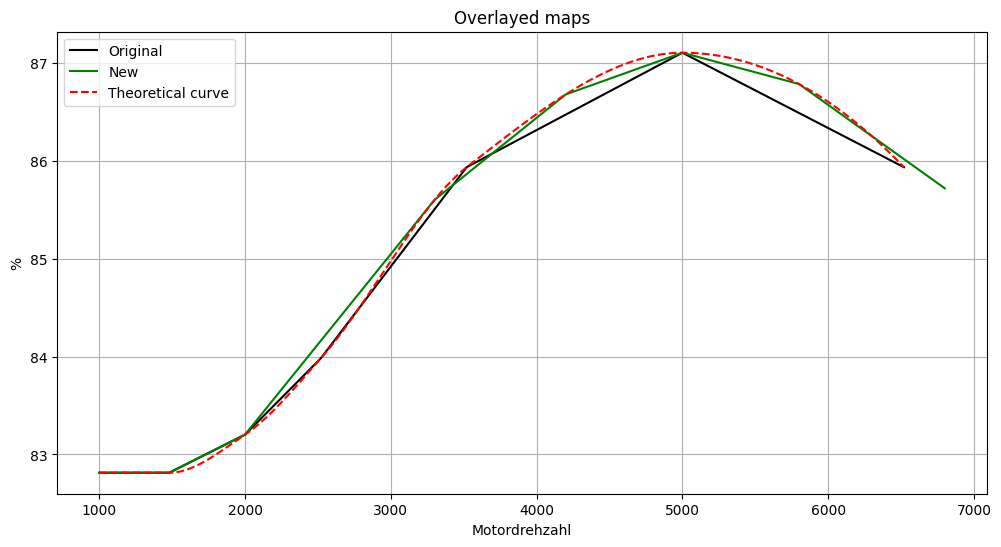

In [81]:
# And this is how it performs
plt.show()